# In this notebook, we are going to implement CNN model to analysis the data
# Applied class weight for the imbalance data.
## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [3]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
7392  HAM_0006379  ISIC_0032937   nv      histo  30.0  female   
1548  HAM_0005608  ISIC_0032685  mel      histo  75.0    male   
3127  HAM_0001931  ISIC_0026755   nv  follow_up  45.0  female   
848   HAM_0006652  ISIC_0031945  bkl  consensus  65.0  female   
7158  HAM_0001615  ISIC_0033348   nv      histo  40.0    male   

         localization  label  
7392             neck      5  
1548             back      4  
3127  upper extremity      5  
848             chest      2  
7158  lower extremity      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [5]:
import math
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])


total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


In [6]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [7]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

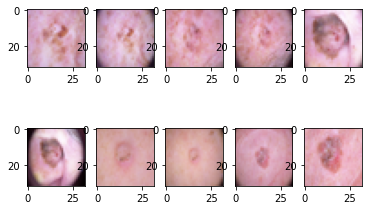

In [8]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [9]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
#data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.20,random_state=87,stratify=label_to_one_hot)

In [10]:
#setup CNN model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,Flatten,Conv2D,MaxPooling2D
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#CNN layer 1:
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


#CNN layer 2
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


#CNN layer 3
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model.add(Flatten())

#hidden layer 1
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.2))

#hidden layer 2
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(7,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [11]:
# Train

batch_size = 256
epochs = 10

train_history = model.fit(
    train_data,train_label,
    epochs=epochs,
    validation_split=0.2,
    batch_size=batch_size,
    verbose=2,class_weight=class_weight)
model.save_weights('CNN.h5')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
26/26 - 12s - loss: 1.5322 - acc: 0.6544 - val_loss: 1.1353 - val_acc: 0.6569
Epoch 2/20
26/26 - 11s - loss: 1.2264 - acc: 0.6726 - val_loss: 1.0986 - val_acc: 0.6569
Epoch 3/20
26/26 - 12s - loss: 1.1625 - acc: 0.6726 - val_loss: 1.1329 - val_acc: 0.6569
Epoch 4/20
26/26 - 12s - loss: 1.1334 - acc: 0.6723 - val_loss: 1.0346 - val_acc: 0.6294
Epoch 5/20
26/26 - 12s - loss: 1.0943 - acc: 0.6758 - val_loss: 0.9964 - val_acc: 0.6419
Epoch 6/20
26/26 - 11s - loss: 1.0711 - acc: 0.6858 - val_loss: 1.0078 - val_acc: 0.6532
Epoch 7/20
26/26 - 12s - loss: 1.0617 - acc: 0.6900 - val_loss: 0.9707 - val_acc: 0.6588
Epoch 8/20
26/26 - 11s - loss: 1.0585 - acc: 0.6887 - val_loss: 0.9593 - val_acc: 0.6663
Epoch 9/20
26/26 - 11s - loss: 1.0509 - acc: 0.6904 - val_loss: 0.9732 - val_acc: 0.6631
Epoch 10/20
26/26 - 11s - loss: 1.0319 - acc: 0.6873 - val_lo

In [12]:
# Train without class weight


#batch_size = 256
#epochs = 50

#train_history_class = model.fit(
#    x=train_data,y=train_label,
#    epochs=epochs,
#    batch_size = batch_size,
#    validation_split=0.2,
#    verbose=2)

In [18]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

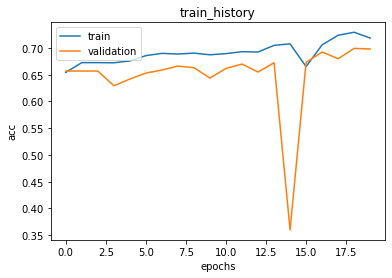

In [19]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

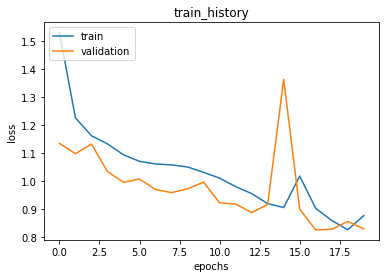

In [20]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [23]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 17ms/step - loss: 0.7909 - acc: 0.7174

In [22]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))


[5 5 5 ... 5 2 2]
predict   0   1    2   4     5   6
label                             
0        10  15   28   0    11   1
1        13  29   27   1    30   3
2         4   4  103   5   104   0
3         4   5    5   0     9   0
4         4   1   36  14   168   0
5         1   9   49  13  1267   2
6         1   1    1   0    11  14
predicted  akiex  bcc  bkl  mel    nv  vasc
actual                                     
akiex         10   15   28    0    11     1
bcc           13   29   27    1    30     3
bkl            4    4  103    5   104     0
df             4    5    5    0     9     0
mel            4    1   36   14   168     0
nv             1    9   49   13  1267     2
vasc           1    1    1    0    11    14
